In [3]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt

from azureml.core import Experiment

In [4]:
import azureml
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.39


In [5]:
ws = Workspace.from_config()
script_folder = '.'
exp = Experiment(workspace=ws, name='keras-mnist')

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


In [6]:
import urllib

os.makedirs('./data/mnist', exist_ok=True)

urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename='./data/mnist/train-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename='./data/mnist/train-labels.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename='./data/mnist/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename='./data/mnist/test-labels.gz')

('./data/mnist/test-labels.gz', <http.client.HTTPMessage at 0x220a7fcb128>)

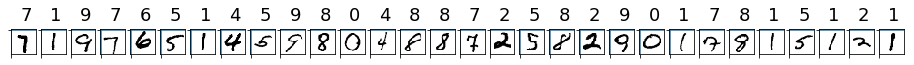

In [8]:
from utils import load_data, one_hot_encode

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster.
X_train = load_data('./data/mnist/train-images.gz', False) / 255.0
y_train = load_data('./data/mnist/train-labels.gz', True).reshape(-1)

X_test = load_data('./data/mnist/test-images.gz', False) / 255.0
y_test = load_data('./data/mnist/test-labels.gz', True).reshape(-1)

count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 10, y = -10, s = y_train[i], fontsize = 18)
    plt.imshow(X_train[i].reshape(28, 28), cmap = plt.cm.Greys)
plt.show()

In [9]:
ds = ws.get_default_datastore()

In [12]:
ds.upload(src_dir='./data/mnist', target_path='mnist', overwrite=True, show_progress=True)

Uploading ./data/mnist\test-images.gz
Uploading ./data/mnist\test-labels.gz
Uploading ./data/mnist\train-images.gz
Uploading ./data/mnist\train-labels.gz
Uploaded ./data/mnist\test-labels.gz, 1 files out of an estimated total of 4
Uploaded ./data/mnist\train-labels.gz, 2 files out of an estimated total of 4
Uploaded ./data/mnist\test-images.gz, 3 files out of an estimated total of 4
Uploaded ./data/mnist\train-images.gz, 4 files out of an estimated total of 4


$AZUREML_DATAREFERENCE_33c5458aedce49b5968470bded6d1783

In [13]:
compute_target = ws.compute_targets['prodmod-compute1']
print(compute_target.get_status().serialize())

{'currentNodeCount': 2, 'targetNodeCount': 2, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 2, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2019-05-21T00:56:52.203000+00:00', 'errors': None, 'creationTime': '2019-05-20T21:19:08.973390+00:00', 'modifiedTime': '2019-05-20T21:20:48.008942+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT600S'}, 'vmPriority': 'LowPriority', 'vmSize': 'STANDARD_D2_V2'}


In [16]:
from azureml.train.dnn import TensorFlow

script_params = {
    '--data-folder': ds.path('mnist').as_mount(),
    '--batch-size': 50,
    '--first-layer-neurons': 300,
    '--second-layer-neurons': 100,
    '--learning-rate': 0.001
}

est = TensorFlow(source_directory=script_folder,
                 script_params=script_params,
                 compute_target=compute_target, 
                 pip_packages=['keras', 'matplotlib'],
                 entry_script='keras_mnist.py', 
                 use_gpu=True)

framework_version is not specified, defaulting to version 1.13.


In [17]:
print(ds.path('mnist').as_mount())

$AZUREML_DATAREFERENCE_06d367a28eda4a6bb82fdc1567e2ce1f


In [18]:
run = exp.submit(est)

In [19]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [20]:
run.wait_for_completion(show_output=True)

RunId: keras-mnist_1558400349_5e73c6d4

Streaming azureml-logs/60_control_log.txt

Streaming log file azureml-logs/60_control_log.txt

Streaming azureml-logs/80_driver_log.txt

/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.


The experiment failed. Finalizing run...
Logging experiment finalizing status in history service
Cleaning up all outstanding Run operations, waiting 300.0 seconds
1 items cleaning up...
Cleanup took 0.2508108615875244 seconds
Traceback (most recent call last):
  File "keras_mnist.py", line 7, in <module>
    import keras
  File "/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/site-packages/keras/__init__.py", line 3, in <module>
    from . import utils
  File "/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/site-

ActivityFailedException: Activity Failed:
{
    "error": {
        "code": "UserError",
        "message": "Traceback (most recent call last):\n  File \"/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py\", line 58, in <module>\n    from tensorflow.python.pywrap_tensorflow_internal import *\n  File \"/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py\", line 28, in <module>\n    _pywrap_tensorflow_internal = swig_import_helper()\n  File \"/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py\", line 24, in swig_import_helper\n    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)\n  File \"/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/imp.py\", line 242, in load_module\n    return load_dynamic(name, filename, file)\n  File \"/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/imp.py\", line 342, in load_dynamic\n    return _load(spec)\nImportError: libcuda.so.1: cannot open shared object file: No such file or directory\n\n\nFailed to load the native TensorFlow runtime.\n\nSee https://www.tensorflow.org/install/errors\n\nfor some common reasons and solutions.  Include the entire stack trace\nabove this error message when asking for help.",
        "details": [],
        "debugInfo": {
            "type": "ImportError",
            "message": "Traceback (most recent call last):\n  File \"/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py\", line 58, in <module>\n    from tensorflow.python.pywrap_tensorflow_internal import *\n  File \"/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py\", line 28, in <module>\n    _pywrap_tensorflow_internal = swig_import_helper()\n  File \"/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py\", line 24, in swig_import_helper\n    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)\n  File \"/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/imp.py\", line 242, in load_module\n    return load_dynamic(name, filename, file)\n  File \"/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/imp.py\", line 342, in load_dynamic\n    return _load(spec)\nImportError: libcuda.so.1: cannot open shared object file: No such file or directory\n\n\nFailed to load the native TensorFlow runtime.\n\nSee https://www.tensorflow.org/install/errors\n\nfor some common reasons and solutions.  Include the entire stack trace\nabove this error message when asking for help.",
            "stackTrace": "  File \"azureml-setup/context_manager_injector.py\", line 95, in execute_with_context\n    runpy.run_path(sys.argv[0], globals(), run_name=\"__main__\")\n  File \"/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/runpy.py\", line 263, in run_path\n    pkg_name=pkg_name, script_name=fname)\n  File \"/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/runpy.py\", line 96, in _run_module_code\n    mod_name, mod_spec, pkg_name, script_name)\n  File \"/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/runpy.py\", line 85, in _run_code\n    exec(code, run_globals)\n  File \"keras_mnist.py\", line 7, in <module>\n    import keras\n  File \"/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/site-packages/keras/__init__.py\", line 3, in <module>\n    from . import utils\n  File \"/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/site-packages/keras/utils/__init__.py\", line 6, in <module>\n    from . import conv_utils\n  File \"/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/site-packages/keras/utils/conv_utils.py\", line 9, in <module>\n    from .. import backend as K\n  File \"/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/site-packages/keras/backend/__init__.py\", line 89, in <module>\n    from .tensorflow_backend import *\n  File \"/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py\", line 5, in <module>\n    import tensorflow as tf\n  File \"/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/site-packages/tensorflow/__init__.py\", line 24, in <module>\n    from tensorflow.python import pywrap_tensorflow  # pylint: disable=unused-import\n  File \"/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/site-packages/tensorflow/python/__init__.py\", line 49, in <module>\n    from tensorflow.python import pywrap_tensorflow\n  File \"/azureml-envs/azureml_d096a8d7572b94fd7a3f28cd37726ace/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py\", line 74, in <module>\n    raise ImportError(msg)\n"
        }
    }
}